In [146]:
import numpy as np
import os
import random
from PIL import Image

# 🎯 Cargar imagen y convertir a vector
def cargar_imagen(path, size=(64, 64)):
    img = Image.open(path).convert('L').resize(size)
    return np.array(img).flatten().astype(np.float32)

# 🧠 Dividir datos en train y test, balanceados
def split_dataset(healthy_dir, parkinson_dir, test_ratio=0.2, size=(64, 64), seed=42):
    random.seed(seed)

    # Obtener paths de imágenes
    healthy_imgs = [os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    parkinson_imgs = [os.path.join(parkinson_dir, f) for f in os.listdir(parkinson_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Mezclar
    random.shuffle(healthy_imgs)
    random.shuffle(parkinson_imgs)

    # Split
    split_h = int(len(healthy_imgs) * (1 - test_ratio))
    split_p = int(len(parkinson_imgs) * (1 - test_ratio))

    train_imgs = healthy_imgs[:split_h] + parkinson_imgs[:split_p]
    test_imgs  = healthy_imgs[split_h:] + parkinson_imgs[split_p:]

    y_train = [0]*split_h + [1]*split_p
    y_test  = [0]*(len(healthy_imgs) - split_h) + [1]*(len(parkinson_imgs) - split_p)

    # Cargar imágenes
    X_train = [cargar_imagen(p, size) for p in train_imgs]
    X_test  = [cargar_imagen(p, size) for p in test_imgs]

    # Mezclar
    train = list(zip(X_train, y_train))
    test  = list(zip(X_test, y_test))
    random.shuffle(train)
    random.shuffle(test)
    X_train, y_train = zip(*train)
    X_test, y_test = zip(*test)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)


In [147]:
X_train, y_train, X_test, y_test = split_dataset(
    healthy_dir="data/raw/Healthy",
    parkinson_dir="data/raw/Parkinson",
    test_ratio=0.2,
    size=(64, 64)
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1304, 4096)
y_train shape: (1304,)
X_test shape: (328, 4096)
y_test shape: (328,)


In [148]:
#EJERCICIO 1 DERIVADAS
# Función de activación
def f_wb(x, w, b):
    return np.tanh(np.dot(x, w) + b)

# Derivadas parciales de la función de pérdida L respecto a w y b
def derivadas_parciales(X, y, w, b):
    f = np.tanh(np.dot(X, w) + b)           # activación
    error = f - y                           # diferencia entre predicción y verdadero

    # derivadas con regla de la cadena (tanh') = 1 - tanh²
    df_dw = 2 * np.dot((error * (1 - f**2)), X) / len(X)
    df_db = 2 * np.sum((error * (1 - f**2))) / len(X)

    return df_dw, df_db


In [ ]:
#EJERCICIO 2 DESCENSO POR GRADIENTE
def train_model(X, y, alpha=0.0001, max_epochs=1000):
    np.random.seed(42)
    w = np.random.randn(X.shape[1]) * 0.01  # inicialización pequeña
    b = 0.0

    loss_history = []

    for epoch in range(max_epochs):
        f = np.tanh(np.dot(X, w) + b)
        error = f - y

        # Derivadas parciales (como en Ej.1)
        grad_w = 2 * np.dot((error * (1 - f**2)), X) / len(X)
        grad_b = 2 * np.sum((error * (1 - f**2))) / len(X)

        # Actualización
        w -= alpha * grad_w
        b -= alpha * grad_b

        # Guardar pérdida cuadrática
        loss = np.mean((f - y)**2)
        loss_history.append(loss)

    return w, b, loss_history


In [150]:
#EJERCICIO 3
def evaluate_model(X, y, w, b):
    pred = np.tanh(np.dot(X, w) + b)
    mse = np.mean((pred - y)**2)
    accuracy = np.mean((pred > 0.5) == (y > 0.5))
    return mse, accuracy


In [151]:
import matplotlib.pyplot as plt
def plot_loss(loss_history):
    plt.plot(loss_history)
    plt.xlabel("Época")
    plt.ylabel("Pérdida cuadrática")
    plt.title("Evolución de la pérdida durante el entrenamiento")
    plt.grid(True)
    plt.show()


Train MSE: 0.5000 | Accuracy: 0.5000
Test  MSE: 0.5000 | Accuracy: 0.5000


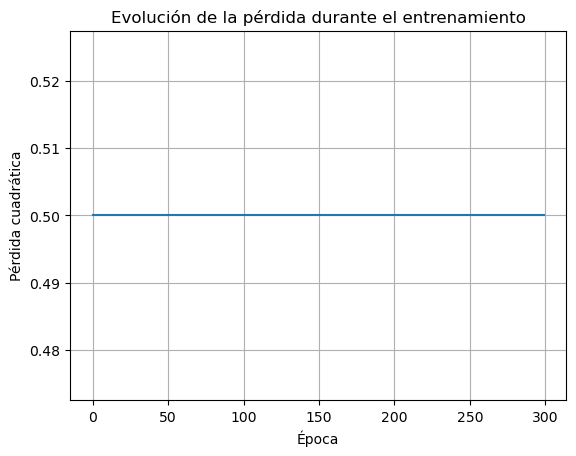

In [152]:
# Entrenar el modelo
import matplotlib.pyplot as plt
w, b, loss_history = train_model(X_train, y_train, alpha=0.01, max_epochs=300)

# Evaluar
mse_train, acc_train = evaluate_model(X_train, y_train, w, b)
mse_test, acc_test = evaluate_model(X_test, y_test, w, b)

print(f"Train MSE: {mse_train:.4f} | Accuracy: {acc_train:.4f}")
print(f"Test  MSE: {mse_test:.4f} | Accuracy: {acc_test:.4f}")

# Graficar pérdida
plot_loss(loss_history)


In [153]:
#EJERCICIO 4 NORMALIZACIÓN
def normalizar_dataset(X):
    return X / 255.0


[Normalizado] Train MSE: 0.2512 | Accuracy: 0.5123
[Normalizado] Test  MSE: 0.2543 | Accuracy: 0.4665


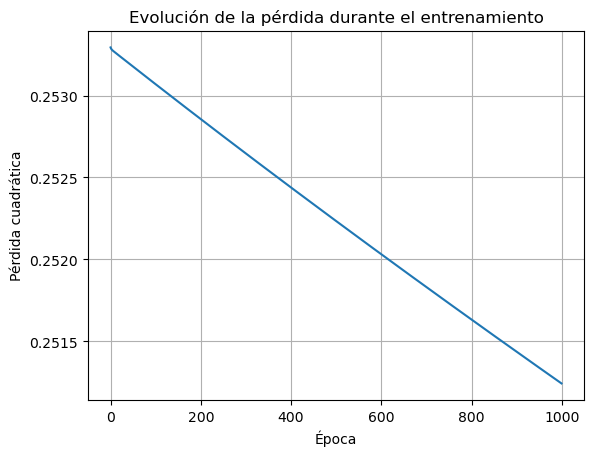

In [154]:
# Normalizar los datos de train y test
X_train_n = normalizar_dataset(X_train)
X_test_n = normalizar_dataset(X_test)

# Entrenar modelo con datos normalizados
w_n, b_n, loss_history_n = train_model(X_train_n, y_train, alpha=0.0001, max_epochs=1000)

# Evaluar
mse_train_n, acc_train_n = evaluate_model(X_train_n, y_train, w_n, b_n)
mse_test_n, acc_test_n = evaluate_model(X_test_n, y_test, w_n, b_n)

print(f"[Normalizado] Train MSE: {mse_train_n:.4f} | Accuracy: {acc_train_n:.4f}")
print(f"[Normalizado] Test  MSE: {mse_test_n:.4f} | Accuracy: {acc_test_n:.4f}")

# Graficar pérdida
plot_loss(loss_history_n)


In [155]:
#EJERCICIO 5
# Lista de alphas a probar
alphas = [0.0001, 0.001, 0.01, 0.05, 0.1]

results = {}

for alpha in alphas:
    w, b, loss_history = train_model(X_train_n, y_train, alpha=alpha, max_epochs=1000)
    mse_test, acc_test = evaluate_model(X_test_n, y_test, w, b)
    results[alpha] = {
        'mse': mse_test,
        'accuracy': acc_test,
        'loss_history': loss_history
    }
    print(f"α = {alpha:.4f} → Test MSE = {mse_test:.4f} | Accuracy = {acc_test:.4f}")


α = 0.0001 → Test MSE = 0.2543 | Accuracy = 0.4665
α = 0.0010 → Test MSE = 0.2623 | Accuracy = 0.5000
α = 0.0100 → Test MSE = 0.5000 | Accuracy = 0.5000
α = 0.0500 → Test MSE = 0.5000 | Accuracy = 0.5000
α = 0.1000 → Test MSE = 0.5000 | Accuracy = 0.5000


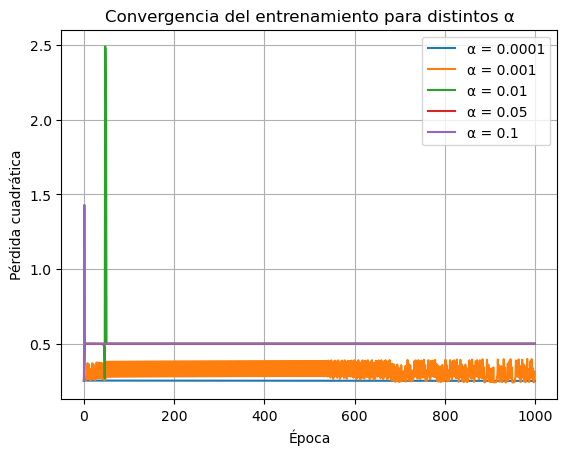

In [157]:
# Comparar gráficamente la evolución de la pérdida
for alpha in alphas:
    plt.plot(results[alpha]['loss_history'], label=f"α = {alpha}")

plt.title("Convergencia del entrenamiento para distintos α")
plt.xlabel("Época")
plt.ylabel("Pérdida cuadrática")
plt.legend()
plt.grid(True)
plt.show()
